In [80]:
!pip3 install torchrl==0.6.0
!pip3 install vmas
!pip3 install pettingzoo[mpe]==1.24.3
!pip3 install tqdm


In [102]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase, is_tensor_collection

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False


try:
    from torch.compiler import is_compiling
except ImportError:
    from torch._dynamo import is_compiling


In [103]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1000  # Number of team frames collected per sampling iteration
n_iters = 500  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters


# Replay buffer
memory_size = 1000000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 1e-4  # Learning rate
max_grad_norm = 1 # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.01  # Tau for the soft-update of the target network


In [104]:
max_steps = 100  # Environment steps before done

n_agents = 2
n_landmarks = 1

use_vmas = True  # Set this to True for a great performance speedup

if not use_vmas:
  base_env = PettingZooEnv(
      task="simple_spread_v3",
      parallel=True,
      seed=seed,
      continuous_actions=True,
      N = n_landmarks
  )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )
    base_env = VmasEnv(
        scenario="simple_spread",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        local_ratio=0.5,
        device=device,
        seed=seed,
        n_agents = n_agents
    )


In [105]:
print(f"group_map: {base_env.group_map}")


group_map: {'agents': ['agent_0', 'agent_1']}


In [106]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)


action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 2, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 2])),
    device=cuda:0,
    shape=torch.Size([10]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([10, 2, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
           

In [107]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)


action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [108]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)


In [109]:
check_env_specs(env)


2025-04-19 00:45:45,228 [torchrl][INFO] check_env_specs succeeded!


In [110]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)


rollout of 5 steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 2, 10]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 2]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 5, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        episode_reward: Tensor(shape=torch.Size([10, 5, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        observation: Tensor(shape=torch.Size([10, 5, 2, 10]), device=cuda:0

In [111]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module


In [112]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy


In [113]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.4,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy


In [114]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence


In [115]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )


Running value and policy for group 'agents': TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 2, 12]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 2, 10]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 2, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 2, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 2]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 1]), device=cuda:0, dty

In [116]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)


In [117]:
#Standard in off policy algos for efficient data collections
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device="cpu"),
        sampler=RandomSampler(),
        batch_size=train_batch_size,
    )
    replay_buffer.append_transform(lambda batch: batch.to(device))
    replay_buffers[group] = replay_buffer


In [118]:
w_plus_prime_const = 0.2
w_minus_prime_const = 0.8

def u_plus(x):
    alpha = 0.7
    return torch.pow(x, alpha)

def u_minus(x):
    alpha = 0.95
    lam = 2.5
    return lam * torch.pow(-x, alpha)

def w_plus_prime(p):
    eta = 0.61
    return eta * torch.pow(p, eta - 1)

def w_minus_prime(p):
    eta = 0.69
    return eta * torch.pow(p, eta - 1)

def compute_phi_linear(R):
    """
    Compute linearized CPT sensitivity:
    φ(R) ≈ w'_+(p*) * u^+(R) for R>=0, and -w'_-(p*) * u^-(R) for R<0.
    """
    R = R.view(-1)
    v = torch.where(R >= 0, u_plus(R), -u_minus(R))
    phi = torch.where(R >= 0, w_plus_prime_const * v, -w_minus_prime_const * v)
    return phi.mean()

def C_transform(x):
    """
    Simple CPT transformation on one-step return:
    C(x) ≈ w'_+(p*) * u^+(x) if x >= 0, else -w'_-(p*) * u^-(x).
    """
    return torch.where(x >= 0, w_plus_prime_const * u_plus(x), -w_minus_prime_const * u_minus(x))

def w_approx_aux(L,x):
    n = (len(L)+1)//3
    breaking_points = L[2*n:]
    for i, elt in enumerate(breaking_points):
        if x < elt:
            return L[2*i]*x + L[2*i+1]
    i = n-1
    return L[2*i]*x + L[2*i+1]
def w_approx(L):
    return (lambda x:w_approx_aux(L,x))

def compute_cpt_integral(trajectory_utilities, w, batch_size):
    """
    Compute the CPT integral using piecewise integration.
    
    Args:
        trajectory_utilities: a list or 1D tensor of utility values (episode returns).
        w: a tuple (function_type, parameters) that defines the weighting function.
           (We assume that a function w_approx(parameters) is available.)
        batch_size: the number of trajectories in the batch.
    
    Returns:
        The estimated CPT value (a float).
    """
    # Convert to a list of floats if necessary.
    if torch.is_tensor(trajectory_utilities):
        utilities = trajectory_utilities.tolist()
    else:
        utilities = [float(x) for x in trajectory_utilities]
    
    # Determine segmentation points (include 0 plus unique outcomes).
    segments = sorted(list(set(utilities + [0])))
    
    # Create segments for gains (non-negative) and losses (non-positive)
    positive_segments = sorted([x for x in segments if x >= 0])
    negative_segments = sorted([-x for x in segments if x <= 0])
    
    res = 0
    if len(segments) == 0:
        return 0
    parameters = w[1]  # extract the parameter list from the tuple
    
    # Integral over gains
    for i in range(len(positive_segments) - 1):
        count = sum(1 for x in utilities if x > positive_segments[i])
        weight = w_approx(parameters)(count / batch_size)
        res += weight * (positive_segments[i+1] - positive_segments[i])
    
    # Integral over losses
    for i in range(len(negative_segments) - 1):
        count = sum(1 for x in utilities if -x > negative_segments[i])
        weight = 1 - w_approx(parameters)(1 - count / batch_size)
        res -= weight * (negative_segments[i+1] - negative_segments[i])
    
    return torch.tensor(res, dtype=torch.float32, device=device)


In [119]:
from __future__ import annotations

from copy import deepcopy
from dataclasses import dataclass
from typing import Tuple

import torch
from tensordict import TensorDict, TensorDictBase, TensorDictParams
from tensordict.nn import dispatch, TensorDictModule

from tensordict.utils import NestedKey, unravel_key
from torchrl.modules.tensordict_module.actors import ActorCriticWrapper
from torchrl.objectives.common import LossModule
from torchrl.objectives.utils import (
    _cache_values,
    _GAMMA_LMBDA_DEPREC_ERROR,
    _reduce,
    default_value_kwargs,
    distance_loss,
    ValueEstimators,
)
from torchrl.objectives.value import TD0Estimator, TD1Estimator, TDLambdaEstimator


class CPTDDPGLoss(LossModule):
    """The DDPG Loss class.

    Args:
        actor_network (TensorDictModule): a policy operator.
        value_network (TensorDictModule): a Q value operator.
        loss_function (str): loss function for the value discrepancy. Can be one of "l1", "l2" or "smooth_l1".
        delay_actor (bool, optional): whether to separate the target actor networks from the actor networks used for
            data collection. Default is ``False``.
        delay_value (bool, optional): whether to separate the target value networks from the value networks used for
            data collection. Default is ``True``.
        separate_losses (bool, optional): if ``True``, shared parameters between
            policy and critic will only be trained on the policy loss.
            Defaults to ``False``, i.e., gradients are propagated to shared
            parameters for both policy and critic losses.
        reduction (str, optional): Specifies the reduction to apply to the output:
            ``"none"`` | ``"mean"`` | ``"sum"``. ``"none"``: no reduction will be applied,
            ``"mean"``: the sum of the output will be divided by the number of
            elements in the output, ``"sum"``: the output will be summed. Default: ``"mean"``.

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> from tensordict import TensorDict
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> batch = [2, ]
        >>> data = TensorDict({
        ...        "observation": torch.randn(*batch, n_obs),
        ...        "action": spec.rand(batch),
        ...        ("next", "done"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "terminated"): torch.zeros(*batch, 1, dtype=torch.bool),
        ...        ("next", "reward"): torch.randn(*batch, 1),
        ...        ("next", "observation"): torch.randn(*batch, n_obs),
        ...    }, batch)
        >>> loss(data)
        TensorDict(
            fields={
                loss_actor: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                loss_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                pred_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
                target_value_max: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False)},
            batch_size=torch.Size([]),
            device=None,
            is_shared=False)

    This class is compatible with non-tensordict based modules too and can be
    used without recurring to any tensordict-related primitive. In this case,
    the expected keyword arguments are:
    ``["next_reward", "next_done", "next_terminated"]`` + in_keys of the actor_network and value_network.
    The return value is a tuple of tensors in the following order:
    ``["loss_actor", "loss_value", "pred_value", "target_value", "pred_value_max", "target_value_max"]``

    Examples:
        >>> import torch
        >>> from torch import nn
        >>> from torchrl.data import Bounded
        >>> from torchrl.modules.tensordict_module.actors import Actor, ValueOperator
        >>> from torchrl.objectives.ddpg import DDPGLoss
        >>> _ = torch.manual_seed(42)
        >>> n_act, n_obs = 4, 3
        >>> spec = Bounded(-torch.ones(n_act), torch.ones(n_act), (n_act,))
        >>> actor = Actor(spec=spec, module=nn.Linear(n_obs, n_act))
        >>> class ValueClass(nn.Module):
        ...     def __init__(self):
        ...         super().__init__()
        ...         self.linear = nn.Linear(n_obs + n_act, 1)
        ...     def forward(self, obs, act):
        ...         return self.linear(torch.cat([obs, act], -1))
        >>> module = ValueClass()
        >>> value = ValueOperator(
        ...     module=module,
        ...     in_keys=["observation", "action"])
        >>> loss = DDPGLoss(actor, value)
        >>> loss_actor, loss_value, pred_value, target_value, pred_value_max, target_value_max = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    The output keys can also be filtered using the :meth:`DDPGLoss.select_out_keys`
    method.

    Examples:
        >>> loss.select_out_keys('loss_actor', 'loss_value')
        >>> loss_actor, loss_value = loss(
        ...     observation=torch.randn(n_obs),
        ...     action=spec.rand(),
        ...     next_done=torch.zeros(1, dtype=torch.bool),
        ...     next_terminated=torch.zeros(1, dtype=torch.bool),
        ...     next_observation=torch.randn(n_obs),
        ...     next_reward=torch.randn(1))
        >>> loss_actor.backward()

    """

    @dataclass
    class _AcceptedKeys:
        """Maintains default values for all configurable tensordict keys.

        This class defines which tensordict keys can be set using '.set_keys(key_name=key_value)' and their
        default values.

        Attributes:
            state_action_value (NestedKey): The input tensordict key where the
                state action value is expected. Will be used for the underlying
                value estimator as value key. Defaults to ``"state_action_value"``.
            priority (NestedKey): The input tensordict key where the target
                priority is written to. Defaults to ``"td_error"``.
            reward (NestedKey): The input tensordict key where the reward is expected.
                Will be used for the underlying value estimator. Defaults to ``"reward"``.
            done (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is done. Will be used for the underlying value estimator.
                Defaults to ``"done"``.
            terminated (NestedKey): The key in the input TensorDict that indicates
                whether a trajectory is terminated. Will be used for the underlying value estimator.
                Defaults to ``"terminated"``.

        """

        state_action_value: NestedKey = "state_action_value"
        priority: NestedKey = "td_error"
        reward: NestedKey = "reward"
        done: NestedKey = "done"
        terminated: NestedKey = "terminated"

    tensor_keys: _AcceptedKeys
    default_keys = _AcceptedKeys
    default_value_estimator: ValueEstimators = ValueEstimators.TD0
    out_keys = [
        "loss_actor",
        "loss_value",
        "pred_value",
        "target_value",
        "pred_value_max",
        "target_value_max",
    ]

    actor_network: TensorDictModule
    value_network: actor_network
    actor_network_params: TensorDictParams
    value_network_params: TensorDictParams
    target_actor_network_params: TensorDictParams
    target_value_network_params: TensorDictParams

    def __init__(
        self,
        actor_network: TensorDictModule,
        value_network: TensorDictModule,
        *,
        loss_function: str = "l2",
        delay_actor: bool = False,
        delay_value: bool = True,
        gamma: float = None,
        separate_losses: bool = False,
        reduction: str = None,
        w: tuple = None
    ) -> None:
        self.w = w
        self._in_keys = None
        if reduction is None:
            reduction = "mean"
        super().__init__()
        self.delay_actor = delay_actor
        self.delay_value = delay_value

        actor_critic = ActorCriticWrapper(actor_network, value_network)
        params = TensorDict.from_module(actor_critic)
        params_meta = params.apply(
            self._make_meta_params, device=torch.device("meta"), filter_empty=False
        )
        with params_meta.to_module(actor_critic):
            self.__dict__["actor_critic"] = deepcopy(actor_critic)

        self.convert_to_functional(
            actor_network,
            "actor_network",
            create_target_params=self.delay_actor,
        )
        if separate_losses:
            # we want to make sure there are no duplicates in the params: the
            # params of critic must be refs to actor if they're shared
            policy_params = list(actor_network.parameters())
        else:
            policy_params = None
        self.convert_to_functional(
            value_network,
            "value_network",
            create_target_params=self.delay_value,
            compare_against=policy_params,
        )
        self.actor_critic.module[0] = self.actor_network
        self.actor_critic.module[1] = self.value_network

        self.actor_in_keys = actor_network.in_keys
        self.value_exclusive_keys = set(self.value_network.in_keys) - (
            set(self.actor_in_keys) | set(self.actor_network.out_keys)
        )

        self.loss_function = loss_function
        self.reduction = reduction
        if gamma is not None:
            raise TypeError(_GAMMA_LMBDA_DEPREC_ERROR)

    def _forward_value_estimator_keys(self, **kwargs) -> None:
        if self._value_estimator is not None:
            self._value_estimator.set_keys(
                value=self._tensor_keys.state_action_value,
                reward=self._tensor_keys.reward,
                done=self._tensor_keys.done,
                terminated=self._tensor_keys.terminated,
            )
        self._set_in_keys()

    def _set_in_keys(self):
        in_keys = {
            unravel_key(("next", self.tensor_keys.reward)),
            unravel_key(("next", self.tensor_keys.done)),
            unravel_key(("next", self.tensor_keys.terminated)),
            *self.actor_in_keys,
            *[unravel_key(("next", key)) for key in self.actor_in_keys],
            *self.value_network.in_keys,
            *[unravel_key(("next", key)) for key in self.value_network.in_keys],
        }
        self._in_keys = sorted(in_keys, key=str)

    @property
    def in_keys(self):
        if self._in_keys is None:
            self._set_in_keys()
        return self._in_keys

    @in_keys.setter
    def in_keys(self, values):
        self._in_keys = values


    def _clear_weakrefs(self, *tds):
        if is_compiling():
            # Waiting for weakrefs reconstruct to be supported by compile
            for td in tds:
                if isinstance(td, str):
                    td = getattr(self, td, None)
                if not is_tensor_collection(td):
                    continue
                td.clear_refs_for_compile_()

    @dispatch
    def forward(self, tensordict: TensorDictBase) -> TensorDict:
        """Computes the DDPG losses given a tensordict sampled from the replay buffer.

        This function will also write a "td_error" key that can be used by prioritized replay buffers to assign
            a priority to items in the tensordict.

        Args:
            tensordict (TensorDictBase): a tensordict with keys ["done", "terminated", "reward"] and the in_keys of the actor
                and value networks.

        Returns:
            a tuple of 2 tensors containing the DDPG loss.

        """
        loss_value, metadata = self.loss_value(tensordict)
        loss_actor, metadata_actor = self.loss_actor(tensordict)
        metadata.update(metadata_actor)
        td_out = TensorDict(
            source={"loss_actor": loss_actor, "loss_value": loss_value, **metadata},
            batch_size=[],
        )
        self._clear_weakrefs(
            tensordict,
            td_out,
            "value_network_params",
            "target_value_network_params",
            "target_actor_network_params",
            "actor_network_params",
        )
        return td_out

    def loss_actor(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified actor loss."""

        td_copy = tensordict.select(
            *self.actor_in_keys, *self.value_exclusive_keys, strict=False
        ).detach()

        with self.actor_network_params.to_module(self.actor_network):
            td_copy = self.actor_network(td_copy)

        with self._cached_detached_value_params.to_module(self.value_network):
            td_copy = self.value_network(td_copy)

        # Get action chosen by policy: μ(o)
        actions = td_copy.get((self.actor_network.in_keys[0][0], "action"))

        # Compute Q-value (state-action value) for current policy
        Q_values = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # Compute Policy Gradient: ∇_a Q(s, a) at a = μ(o)
        grad_Q = torch.autograd.grad(Q_values.sum(), actions, retain_graph=True)[0]  # (batch_size, action_dim)

        # Compute CPT-derived adjustment (phi transformation)
        group = self.actor_network.in_keys[0][0]  # Extracts the group key (e.g., "adversary")
        returns = tensordict.get((group, "episode_reward")).view(-1)  # Sum of rewards over episode
        # phi_factor = compute_cpt_integral(returns, self.w, returns.numel())
        # # print(
        # #     f"DEBUG phi_factor → type: {type(phi_factor)}, "
        # #     f"value: {phi_factor}, "
        # #     f"is_tensor: {isinstance(phi_factor, torch.Tensor)}"
        # # )
        # phi_factor = phi_factor.abs()
        phi_factor = compute_cpt_integral(returns, self.w, returns.numel())
        phi_factor = phi_factor.abs()
        policy_gradient = actions * grad_Q  # Chain rule term: ∇_θ μ(o) ∇_a Q(s, a)
        loss_actor = -phi_factor * policy_gradient.mean()  # CPT-adjusted loss

        return _reduce(loss_actor, self.reduction), {}

    def loss_value(self, tensordict: TensorDictBase) -> Tuple[torch.Tensor, dict]:
        """Compute the CPT-modified critic loss."""
        td_copy = tensordict.select(*self.value_network.in_keys, strict=False).detach()
        with self.value_network_params.to_module(self.value_network):
            self.value_network(td_copy)
        pred_val = td_copy.get(self.tensor_keys.state_action_value).squeeze(-1)

        # Standard target value calculation
        target_value = self.value_estimator.value_estimate(
            tensordict, target_params=self._cached_target_params
        ).squeeze(-1)

        # Apply CPT transformation
        target_value_CPT = C_transform(target_value)

        # Compute CPT critic loss
        loss_value = distance_loss(pred_val, target_value_CPT, loss_function=self.loss_function)

        # Update tensor dictionary with CPT-transformed target
        tensordict.set("target_value_CPT", target_value_CPT, inplace=True)

        # Compute TD error for prioritized replay buffer
        td_error = (pred_val - target_value_CPT).pow(2).detach()
        tensordict.set(self.tensor_keys.priority, td_error, inplace=True)

        metadata = {
            "td_error": td_error,
            "pred_value": pred_val,
            "target_value_CPT": target_value_CPT,
        }
        return _reduce(loss_value, self.reduction), metadata

    def make_value_estimator(self, value_type: ValueEstimators = None, **hyperparams):
        if value_type is None:
            value_type = self.default_value_estimator
        self.value_type = value_type
        hp = dict(default_value_kwargs(value_type))
        if hasattr(self, "gamma"):
            hp["gamma"] = self.gamma
        hp.update(hyperparams)
        if value_type == ValueEstimators.TD1:
            self._value_estimator = TD1Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.TD0:
            self._value_estimator = TD0Estimator(value_network=self.actor_critic, **hp)
        elif value_type == ValueEstimators.GAE:
            raise NotImplementedError(
                f"Value type {value_type} it not implemented for loss {type(self)}."
            )
        elif value_type == ValueEstimators.TDLambda:
            self._value_estimator = TDLambdaEstimator(
                value_network=self.actor_critic, **hp
            )
        else:
            raise NotImplementedError(f"Unknown value type {value_type}")

        tensor_keys = {
            "value": self.tensor_keys.state_action_value,
            "reward": self.tensor_keys.reward,
            "done": self.tensor_keys.done,
            "terminated": self.tensor_keys.terminated,
        }
        self._value_estimator.set_keys(**tensor_keys)

    @property
    @_cache_values
    def _cached_target_params(self):
        target_params = TensorDict(
            {
                "module": {
                    "0": self.target_actor_network_params,
                    "1": self.target_value_network_params,
                }
            },
            batch_size=self.target_actor_network_params.batch_size,
            device=self.target_actor_network_params.device,
        )
        return target_params

    @property
    @_cache_values
    def _cached_detached_value_params(self):
        return self.value_network_params.detach()


In [120]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = CPTDDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
        w=(0, [ 1.94671279,  0.,  0.69678392,  0.11132902,  2.70977837,
       -1.70977837,  0.08906833,  0.90467621])
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}


In [121]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch


In [122]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

grad_norms = []
# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]
                # print(type(phi_factor), phi_factor, isinstance(phi_factor, torch.Tensor))
                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                temp = torch.nn.utils.clip_grad_norm_(params, max_grad_norm)
                total_norm = 0.0
                # for p in params:
                #     if p.grad is not None:
                #         total_norm += p.grad.data.norm(2).item() ** 2
                # total_norm = total_norm ** 0.5
                # grad_norms.append(total_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()



episode_reward_mean_agents = -382.0019226074219:   4%|▍         | 21/500 [00:39<15:01,  1.88s/it]

episode_reward_mean_agents = -363.1314392089844:   0%|          | 1/500 [00:01<11:34,  1.39s/it]
episode_reward_mean_agents = -674.0586547851562:   0%|          | 2/500 [00:02<11:33,  1.39s/it]
episode_reward_mean_agents = -615.23388671875:   1%|          | 3/500 [00:04<11:33,  1.40s/it]  
episode_reward_mean_agents = -639.3682250976562:   1%|          | 4/500 [00:05<12:07,  1.47s/it]
episode_reward_mean_agents = -928.3449096679688:   1%|          | 5/500 [00:07<11:52,  1.44s/it]
episode_reward_mean_agents = -875.8380737304688:   1%|          | 6/500 [00:08<11:45,  1.43s/it]
episode_reward_mean_agents = -687.8705444335938:   1%|▏         | 7/500 [00:09<11:37,  1.42s/it]
episode_reward_mean_agents = -796.4594116210938:   2%|▏         | 8/500 [00:11<11:34,  1.41s/it]
episode_reward_mean_agents = -899.0021362304688:   2%|▏         | 9/500 [00:12<11:32,  1.41s/it]
episode_reward_mean_agents 

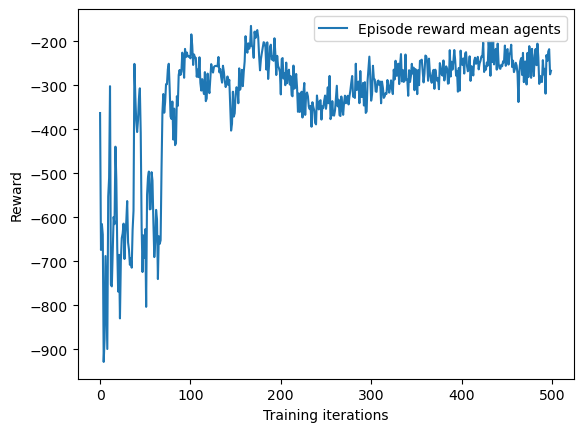

dict_keys(['agents'])


In [124]:
fig, axs = plt.subplots(1, 1)
for i, group in enumerate(env.group_map.keys()):
    axs.plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs.set_ylabel("Reward")
    axs.legend()
axs.set_xlabel("Training iterations")
plt.show()
print(env.group_map.keys())


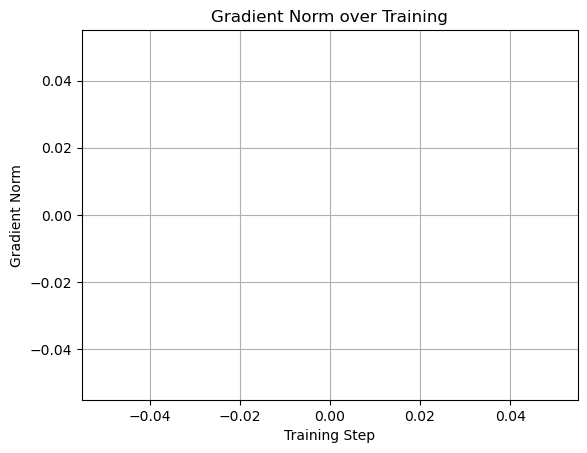

In [47]:
plt.figure()
plt.plot(grad_norms)
plt.xlabel("Training Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm over Training")
plt.grid(True)
plt.show()